### Tridesclous Autosorter: Sanford Datalogger (Headstage)
- **Andy Gibson, 9/22/25**
- University of California, San Diego
- Neural Crossroads Lab, Dr. Lara Rangel

Note to user: This code was painstakingly designed to run well on MacOS, since the documentation for Tridesclous, SpikeInterface, Phy, etc. are primarily built for Windows. Actually, "run well" is a misleading overstatement. The following script only achieved success through brute force and trial and error. If you are using Windows, it may be preferrable to write a script for Tridesclous and SpikeInterface by following their documentation or by heavily adapting this notebook and removing unnecessary blocks. If you are an Apple user, hopefully this makes your life easier. Run at your own risk :)

In [1]:
# enviornment check specific to my computer (just change "spikes" to your environment)

import os

# checks if we're in the right conda environment
current_env = os.environ.get('CONDA_DEFAULT_ENV', 'unknown')

if current_env != 'spikes':
    print(f'Detected incorrect environment: {current_env}')
    print("Run 'conda activate spikes' first")
    raise SystemExit()
else:
    print(f'Andy environment check passed: {current_env}')

Andy environment check passed: spikes


### MacOs compatibility information
You can ignore this if using Windows. There are a number of blocks in this notebook that are specific to the MacOs compatibility struggle
with TDC and SpikeInterface, etc.
- **Zugbruecke** info: https://github.com/pleiszenburg/zugbruecke/blob/master/README.md

```pip install zugbruecke``` (or use different install method)

- **Rosetta**
```softwareupdate --install-rosetta --agree-to-license```

- **XQuartz** (may be required by certain version of wine)
```brew install --cask xquartz```

- **gcenx wine** (i'm using apple silicon, but this might be different for older chips)
```brew tap gcenx/wine```
\
```brew install --cask --no-quarantine wine-crossover```

Restart the notebook and then run this in the terminal:

```echo 'export PATH="/Applications/Wine Crossover.app/Contents/Resources/wine/bin:$PATH"' >> ~/.zprofile``` \
```source ~/.zprofile```


### Cleaned Version

#### Step 0: Imports + silence future warnings

In [2]:
"""
Warning: Most of my issues involved dep conflicts. Avoid installing additional packages unless absolutely necessary. I highly recommend
creating a fresh environment for this notebook.
"""

from pathlib import Path
from datetime import datetime
import os
import numpy as np
import pandas as pd
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
from spikeinterface.extractors import read_binary
from spikeinterface.core import BinaryFolderRecording, write_binary_recording # specific for datalogger files
import spikeinterface.sorters as ss
from spikeinterface.exporters import export_to_phy
from probeinterface import Probe, ProbeGroup

In [3]:
import warnings # totally optional, but otherwise the output will have tons of harmless, but annoying deprecation warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#### Step 1: Make Wine visible to .PL2 reader in Neo (MacOS only)

In [4]:
## this part is a struggle and you may need to make changes depending on what you want to do

# connect zugbruecke with crossover’s wine
wine_dir = "/Applications/Wine Crossover.app/Contents/Resources/wine/bin"
wine_bin = os.path.join(wine_dir, "wine")
assert os.path.exists(wine_bin), f"Wine not found at {wine_bin}"

os.environ["ZUGBRUECKE_WINE"] = wine_bin
os.environ["PATH"] = wine_dir + ":" + os.environ.get("PATH", "")

# run wenv offline (avoids a later pip error)
os.environ["WENV_OFFLINE"] = "1"

# avoids annoying logging
os.environ["WINEDEBUG"] = "-all"

#### Step 2: Folders and .PL2 file paths

In [5]:
# note to user: just change the path
dl_pl2_root = Path('/Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/Raw Datalogger .PL2s')

# batch processing checklist
# there is an annoying Wine bug that means we can only do one file per session, so I use this manual checklist
# manually mark files as 'done' after they finish, change current_file before each run, then restart the kernel
files_to_sort = [
    ('CH4a_Day1_ArenaFinal_09282023_DL.pl2', 'done'),            # finished
    ('CH4a_Day2_ArenaFinal_09292023_DL.pl2', 'current'),         # finished
    # ('CH4a_Day3_ArenaFinal_09302023_DL.pl2', 'next'),          # this one is up next
    # add more here
]

# the current file to run right now
current_file = 'CH4a_Day2_ArenaFinal_09292023_DL.pl2'
pl2_files = [dl_pl2_root / current_file]

# comprehensive status check with file diagnostics
print(f"looking in: {dl_pl2_root}")
print(f"directory exists: {dl_pl2_root.exists()}\n")

print("files processed:")
for fname, status in files_to_sort:
    fpath = dl_pl2_root / fname
    if status == 'done':
        print(f"  ✔ {fname}")
    elif status == 'current':
        print(f"  → {fname} (current)")
        # show detailed info for current file
        if fpath.exists():
            print(f"     exists: True")
            print(f"     size: {fpath.stat().st_size / (1024**3):.2f} GB")
        else:
            print(f"     exists: False *** ERROR ***")
    elif status == 'next':
        print(f"  ⋯ {fname} (up next)")
    else:
        print(f"    {fname} (not started)")

print(f"\nprocessing: {current_file}")

# make sure we're only doing one file (Wine will crash otherwise)
if len(pl2_files) != 1:
    print(f'WARNING: found {len(pl2_files)} files, should be 1')

# final existence check before we try to run
if not pl2_files[0].exists():
    print(f"\nERROR: can't find {current_file}")
    print("check the path and filename spelling")
else:
    print(f"\nready to process:")
    print(f"  file: {pl2_files[0].name}")
    print(f"  size: {pl2_files[0].stat().st_size / (1024**3):.2f} GB")
    print(f"  path: {pl2_files[0]}")
    print("\nafter this finishes:")
    print("  - mark as 'done' in files_to_sort")
    print("  - change current_file to next one")
    print("  - restart kernel and run all")

looking in: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/Raw Datalogger .PL2s
directory exists: True

files processed:
  ✔ CH4a_Day1_ArenaFinal_09282023_DL.pl2
  → CH4a_Day2_ArenaFinal_09292023_DL.pl2 (current)
     exists: True
     size: 3.54 GB

processing: CH4a_Day2_ArenaFinal_09292023_DL.pl2

ready to process:
  file: CH4a_Day2_ArenaFinal_09292023_DL.pl2
  size: 3.54 GB
  path: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/Raw Datalogger .PL2s/CH4a_Day2_ArenaFinal_09292023_DL.pl2

after this finishes:
  - mark as 'done' in files_to_sort
  - change current_file to next one
  - restart kernel and run all


#### Step 3: Helper functions

In [18]:
def set_tetrode_groups_from_names(rec):
    """
    Divine a tetrode group index for every channel from it's Plexon name using the three numbers at the end: WB01, WB05, WB09, 
    013, 017... 029. Returns the input recording with an additional group property which is a vector of group IDs (later used to autosort 
    by tetrode group instead of individual electrodes).

    *Of course, this is specific to Plexon files, the Sanford experiment, and our lab's settings, but could easily be adapted.
    """
    def _trailing_ints(tname, default=1):
        """Internal function that returns an integer made from the trailing digits of tname (tetrode name). Returns a default of 1 if 
        there aren't any digits at the end of the name."""
        tname = str(tname) # safety!
        idx = len(tname) - 1 # set idx as last position in name (should be 7 for our wide-band tetrode data)
        # loop backwards over the digits
        while idx >= 0 and tname[idx].isdigit(): # scan from the end of the str and extract the digits at the end
            idx -= 1
        digits = tname[idx+1:] # slice out the trailing digits using tname[idx+1:]

        if digits:
            int_out = int(digits)
        else:
            int_out = default
        
        return int_out

    names = np.asarray(rec.channel_ids, dtype=object) # turn chan ids from recording obj into a NumPy vector
    groups = np.empty(len(names), dtype=int) # initialize empty array of len = num channels to later fill with each channel's tetrode group

    for idx, nm in enumerate(names):
        trail_nums = _trailing_ints(nm, default=1) # keep same default (default) as in helper's helper
        groups[idx] = (trail_nums - 1) // 4 # assign tetrode idx for ea channel, so [1, 2, 3, 4] -> 0, [5, 6, 7, 8] -> 1, etc...

    # using SpikeInterface API, save tetrode groups as a per-channel property called "group" on input recording
    rec.set_property('group', groups)
    
    return rec
    
def _attach_probe_from_groups(rec, contact_spacing_um=20.0, tetrode_pitch_um=120.0):
    """
    Using ProbeInterface, construct a ProbeGroup from the recording's "group" property and attach it to rec (meaning one probe per 
    tetrode). Returns a new recording which holds the attached ProbeGroup geometry.

    Recording layout:
      - Contact spacing = 20um and tetrode pitch = 120um
          - Contact spacing : the distance between each of the 4 electrodes in a tetrode build
          - Tetrode pitch : the distance between neighboring tetrodes along the x-axis
      - Position each tetrode's 4 contacts in a 2 by 2 square
      - Tetrodes are placed along the x-axis with pitch = tetrode_pitch_um
    """
    groups = np.asarray(rec.get_property('group'), dtype=int)  # extract group per-channel array from rec, convert to NumPy int array
    n_tet = int(groups.max()) + 1

    pg = ProbeGroup()
    for g in range(n_tet): # g := current tetrode group number, ie 0, 1, 2, 3...
        ch_idx = np.where(groups == g)[0] # find all channel idxs with group property == g
        if ch_idx.size: # confirm tetrode actually has channels/skip empty groups
            n_chan = ch_idx.size # n_chan := num of chans in tetrode == 4... except stereotrodes??!****

            # set 2 by 2 per tet contact positions, wrapping every 4
            r = np.arange(n_chan) % 4 # r := contact/electrode idxs [0, 1, 2, 3], [0, 1, 2, 3], etc... with len = n_chan
            pos = np.empty((n_chan, 2), dtype=float) # array of x, y positions for each electrode measured in um

            # set x coors for r vals [0, 1, 2, 3] becomes [0, d, 0, d], where d = contact spacing
            pos[:, 0] = (r % 2) * contact_spacing_um
            # set y coors for r vals [0, 1, 2, 3] becomes [0, 0, d, d], where d = contact spacing
            pos[:, 1] = (r // 2) * contact_spacing_um

            p = Probe(ndim=2, si_units='um') # create probe as a 2D ProbeInterface obj in um

            # set contact pos and graphics shape as circles of radius 5um for later visualization
            p.set_contacts(positions=pos, shapes='circle', shape_params={'radius': 5})
            p.set_device_channel_indices(ch_idx) # map contacts to channel idxs to align with the order of data in rec (device = raw)
            p.move((g * tetrode_pitch_um, 0.0)) # order tets side by side on x-axis and translate by the pitch
            p.create_auto_shape() # outline contacts for later visualization
            pg.add_probe(p) # add current tet's p to probe group

    return rec.set_probegroup(pg) # integrate with SpikeInterface by attaching pg to rec

def list_pl2_streams(pl2_path):
    """
    Summarizes continuous Plexon .PL2 streams into a dictionary that includes names, sampling rates, and channel counts. This 
    will need to be modified if you're going to use other types of files. Includes safe handling of differences in stream and channel names. 
    Flow: use stream name first and decode bytes to strings if needed, then fall back to channel name via leading letters. If that doesn't 
    work, mark as "unknown". Tells us which streams are present, num channels, and sampling rate.
    
    Returns a dict like: {'WB': {'sr': max sampling rate, 'n': number of channels}}, where the outer key is the stream name

    *Note: This doesn't need Wine b/c Neo's Plexon2RawIO is cross-platform :D
    """
    from neo.rawio.plexon2rawio import Plexon2RawIO

    def _leading_letters(string):
        """Extract leading letters or hyphens, i.e. "WB" from "WB25"."""
        string = str(string)
        out_chars = []
        for ch in string:
            if ch.isalpha() or ch == '-': # append char if is letter or hyphen
                out_chars.append(ch)
            else: # stop at first non-letter/hyphen
                break
        return ''.join(out_chars) or string  # just return original str if there's no prefix

    pl2_path = Path(pl2_path) # make Path obj for handling
    io = Plexon2RawIO(filename=str(pl2_path)) # Plexon-specifc reader io instance bound to .PL2 file
    io.parse_header()

    sigs = io.header['signal_channels'] # define NumPy array containing channel properties: name, sampling rate, channel counts
    fields = sigs.dtype.names
    # record the field names that exist for this .PL2 file (note: this can differ b/w .PL2 files!)
    have_stream_name = 'stream_name' in fields
    have_name = 'name' in fields
    have_sr = 'sampling_rate' in fields

    streams = {}
    for row in range(sigs.shape[0]): # loop across channels (row = row index)
        sampling_rate_hz = float(sigs['sampling_rate'][row]) if have_sr else float('nan') # extract sampling rate in Hz, default to NaN

        # key = either stream's real group id or leading letters (i.e. "WB")
        if have_stream_name: # plan a: try to use explicit stream name first
            raw = sigs['stream_name'][row]
            # sometimes .PL2 files can store stream names as bytes instead of strings...
            key = raw if isinstance(raw, str) else raw.decode(errors='ignore') # id for stream; use to group chans else decode bytes obj
        elif have_name: # plan b: use chan name and divine leading letters from the str
            raw = sigs['name'][row]
            nm = raw if isinstance(raw, str) else raw.decode(errors='ignore')
            key = _leading_letters(nm)
        else: # plan c: label as unknown
            key = 'unknown'

        sdict = streams.setdefault(key, {'sr': sampling_rate_hz, 'n': 0}) # summary of streams dict for the key holding sr and n
        sdict['n'] += 1 # for this stream, increment channel number/count starting at 0
        if sampling_rate_hz > sdict['sr']:
            sdict['sr'] = sampling_rate_hz # keep max sr for chans with the same key, in case of difference
        
    return streams

    # should return a dict of format {'WB': {'sr': 30000.0, 'n': 32}, 'ANALOG': {'sr': 1000.0, 'n': 4}}

def _compute_noise_levels(recording, duration_sec=10.0):
    """
    Compute noise levels via MAD estimation from the middle of a recording. Returns noise per channel.
    I use this for both bad channel detection AND adaptive threshold scaling so I only compute it once and just pass it around.
    
    duration_sec: how many secs to use from middle of recording
    """
    fs = recording.get_sampling_frequency()
    total_frames = recording.get_num_frames()
    
    # sample from middle to avoid edge artifacts or initialization weird stuff
    start_frame = total_frames // 2
    end_frame = min(start_frame + int(duration_sec * fs), total_frames)
    trace_chunk = recording.get_traces(start_frame=start_frame, end_frame=end_frame)
    
    # MAD-based noise estimation (multiply by 1.4826 to convert MAD to std for normal dist)
    noise_levels = np.median(np.abs(trace_chunk - np.median(trace_chunk, axis=0)), axis=0) * 1.4826
    
    return noise_levels

def _find_column_flexible(columns, candidates=None, must_contain=None, default=None):
    """
    Flexible helper to find column names in dataframes when the exact name varies between SI versions or output formats.
    Used throughout the notebook to robustly handle .csv reading and quality metric extraction.
    
    candidates: list of exact column names to try first
    must_contain: list of tokens that must all be in the column name
    default: what to return if nothing found, None will raise an error
    """
    cols_lower = {c.lower(): c for c in columns}
    
    # try exact matches first (this is case-insensitive!!)
    if candidates:
        for c in candidates:
            if c.lower() in cols_lower:
                return cols_lower[c.lower()]
    
    # fall back to substring matching if must_contain is specified
    if must_contain:
        must_contain_lower = [tok.lower() for tok in must_contain]
        for c in columns:
            name_l = c.lower()
            if all(tok in name_l for tok in must_contain_lower):
                return c
    
    # no match found
    if default is not None:
        return default
    
    raise ValueError(f"No matching column found. Candidates: {candidates}, Must contain: {must_contain}")

In [7]:
# optional call to check for the correct stream with imported files
list_pl2_streams(pl2_files[0])

C:\python-3.7.4.stable\python.exe: can't open file '/opt/homebrew/anaconda3/envs/spikes/share/wenv/cache/get-pip.py': [Errno 2] No such file or directory


{'WB': {'sr': 40000.0, 'n': 32}}

#### Step 4: Loader (prefer the wideband stream)

In [8]:
def load_recording_pl2(pl2_path, prefer_stream='WB', verbose=True):
    """
    Opens a .PL2 on input file path with SpikeInterface, trying Plexon2RecordingExtractor, and select the wideband stream by name, which 
    should be "WB". Verbose is important because it shows you processes status prints in real time.
    """
    si_kwargs = {'stream_name': prefer_stream} if prefer_stream else {} # creat dict of key args -> pass into SI
    if verbose: # if true print file opened and which stream (or use default)
        print(f"Opening .pl2: {pl2_path}")
        print(f"Selecting .pl2 stream: {si_kwargs if si_kwargs else '(library default)'}")

    rec = se.Plexon2RecordingExtractor(pl2_path, **si_kwargs) # note: points to chosen stream, but SpikeInterface uses "lazy loading"
    # actual reading of signals and channel metadata is done later when called

    sampling_rate_hz = float(rec.get_sampling_frequency()) # use extractor to store sr as a float

    if verbose:
        fs_round = round(sampling_rate_hz, 2)
        print(f"Reading .pl2 fine - channels: {rec.get_num_channels()}, fs: {fs_round} Hz") # for clean printing

    return rec

#### Step 5: Light preprocessing

In [9]:
def preprocess_recording(rec, notch_line=True, extra_notch_hz=None):
    """Basic preprocessing, including bandpass filter between 400 and 5000 Hz, a notch filter, extra notch filter, and common reference.
    """
    rec_pp = spre.bandpass_filter(rec, 400.0, 5000.0, dtype='float32') # bandpass 400-5000Hz to isolate spikes
    
    if notch_line: # notch_line filter to remove powerline noise in US/Can
        rec_pp = spre.notch_filter(rec_pp, freq=60.0)
    if extra_notch_hz: # optional for equipment interference frequencies
        rec_pp = spre.notch_filter(rec_pp, freq=float(extra_notch_hz))

    # remove volume conduction; the median is less effected by chans with high magnitude spikes
    rec_pp = spre.common_reference(rec_pp, reference='global', operator='median')
    
    return rec_pp

#### Step 6: Deal with potential datalogger initialization artifacts [Optional]

In [10]:
def detect_and_remove_initialization_artifact(recording, check_duration_sec=5.0, threshold_factor=10):
    """
    Check if there's a huge artifact at the start of the recording (can be a common problem with wireless headstage initialization, 
    including ours) and figure out how much to shave off. Returns frame_slice params.
    
    Important stuff:
    -> check_duration_sec: how many seconds to scan at the beginning
    -> threshold_factor: call it an artifact if amp > threshold_factor * median amp
    """
    fs = recording.get_sampling_frequency()
    check_frames = int(check_duration_sec * fs)
    
    # pull first few seconds
    trace_start = recording.get_traces(start_frame=0, end_frame=min(check_frames, recording.get_num_frames()))
    
    # compare max abs amp in first second vs. rest of check window
    first_sec = int(1.0 * fs)
    amp_first_sec = np.abs(trace_start[:first_sec, :]).max()
    amp_rest = np.median(np.abs(trace_start[first_sec:, :]))
    
    if amp_first_sec > threshold_factor * amp_rest:
        # scan through to find where things settle
        window_size = int(0.1 * fs)  # 100ms windows
        max_amps = []
        for i in range(0, check_frames - window_size, window_size):
            window = trace_start[i:i+window_size, :]
            max_amps.append(np.abs(window).max())
        
        # find first window where amp looks normal
        median_amp = np.median(max_amps[5:])  # later windows = baseline
        for i, amp in enumerate(max_amps):
            if amp < 3 * median_amp:
                trim_frames = i * window_size
                print(f"  initialization artifact detected, trimming first {trim_frames/fs:.2f} sec")
                return trim_frames, None
        
        # fallback if no clean window found
        print(f"  artifact detected but unclear when it ends, trimming first 2.0 sec to be safe")
        return int(2.0 * fs), None
    
    print(f"  no initialization artifact found")
    return 0, None

#### Step 7: Find and exclude bad channels *DANGER* [Optional]

In [11]:
def identify_bad_channels(recording, noise_levels=None, noise_threshold_factor=3.0, return_recording=True):
    """
    Find bad channels by looking at noise floor. If a channel has way more noise than the others, it's probably garbage.
    Can either return a cleaned recording or just the list of bad channel IDs.
    
    noise_levels: pre-computed noise per channel (if None, will compute on the fly)
    noise_threshold_factor: channel is bad if its noise > factor * median noise across all chans
    return_recording: if True returns cleaned rec, if False returns list of bad chan IDs
    """
    # compute noise if not provided (but ideally it's passed in to avoid redundant computation)
    if noise_levels is None:
        noise_levels = _compute_noise_levels(recording, duration_sec=10.0)
    
    median_noise = np.median(noise_levels)
    
    # flag outliers
    bad_mask = noise_levels > (noise_threshold_factor * median_noise)
    bad_channels = [recording.channel_ids[i] for i, is_bad in enumerate(bad_mask) if is_bad]
    
    if bad_channels:
        print(f"  found {len(bad_channels)} noisy channels (>{noise_threshold_factor}x median): {bad_channels}")
        if return_recording:
            return recording.remove_channels(bad_channels), bad_channels
        return bad_channels
    else:
        print(f"  all channels look okay (within {noise_threshold_factor}x median noise)")
        if return_recording:
            return recording, []
        return []

#### Step 8: Find and exclude lab-specific equipment artifacts [Optional]

In [12]:
def detect_and_remove_narrowband_artifacts(recording, freq_range=(1000, 5000), 
                                           psd_threshold=5.0, apply=True):
    """
    Look for sharp peaks in the power spectrum that probably come from equipment artifacts (like the 3.5kHz spike from the datalogger). 
    Option to turn on notch filters to terminate them.
    
    freq_range: which frequency range to check for artifacts (Hz)
    psd_threshold: consider it an artifact if peak PSD > threshold * median PSD in that range
    apply: if True, actually apply the notch filters; if False just report what was found
    
    Returns: possibly filtered recording, list of artifact freqs
    """
    from scipy import signal as scipy_signal
    
    # sample one channel to find artifacts (they usually show up on all chans)
    fs = recording.get_sampling_frequency()
    duration = min(10.0, recording.get_num_frames() / fs)  # use first 10 sec
    trace = recording.get_traces(start_frame=0, 
                                 end_frame=int(duration * fs),
                                 channel_ids=[recording.channel_ids[0]])
    
    # compute power spectra
    freqs, psd = scipy_signal.welch(trace[:, 0], fs=fs, nperseg=4096)
    
    # only look in the specified range
    freq_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    psd_in_range = psd[freq_mask]
    freqs_in_range = freqs[freq_mask]
    
    median_psd = np.median(psd_in_range)
    
    # try to find peaks
    from scipy.signal import find_peaks
    peaks, properties = find_peaks(psd_in_range, height=psd_threshold * median_psd, prominence=median_psd)
    
    artifact_freqs = freqs_in_range[peaks]
    
    if len(artifact_freqs) > 0:
        print(f"  narrowband artifacts detected at: {[f'{f:.0f}Hz' for f in artifact_freqs]}")
        
        if apply:
            rec_filtered = recording
            for freq in artifact_freqs:
                rec_filtered = spre.notch_filter(rec_filtered, freq=float(freq), q=10)
            return rec_filtered, artifact_freqs
        return recording, artifact_freqs
    else:
        print(f"  no narrowband artifacts in {freq_range[0]}-{freq_range[1]} Hz range")
        return recording, []

#### Step 9: Tridesclous single file pipeline, .csvs, export to Phy

In [13]:
def run_tridesclous_on_rec(rec, out_root, noise_levels=None, base_detect_threshold=5, min_cluster_size=60, min_firing_rate_hz=0.1):
    """
    Runs TriDesclous autosort pipeline on rec per tetrode (using the assigned property='group'), builds a SortingAnalyzer, exports a Phy 
    project, and returns: (sorting, analyzer, counts_df). Now uses adaptive detection threshold based on actual noise levels in the 
    recording instead of hardcoding a threshold. Also filters out low-quality units based on cluster size and firing rate.
    
    noise_levels: pre-computed noise per channel (if None, will compute on the fly). Pass this in from the driver to avoid redundant work.
    base_detect_threshold: starting point for detection threshold, gets scaled by noise levels
    min_cluster_size: minimum spikes in catalog for a cluster to be considered real (adaptive based on recording duration)
    min_firing_rate_hz: minimum firing rate for a unit to be kept (helps remove noise clusters)
    
    For analysis outside of Phy, this function generates .csvs saved under {out_root}/reports:
      - units_per_tetrode.csv
      - per_unit_sparsity.csv
    """
    out_root = Path(out_root)
    run_folder = out_root / 'tridesclous_output' / datetime.now().strftime('%Y%m%d_%H%M%S')
    run_folder.parent.mkdir(parents=True, exist_ok=True)
    
    # use pre-computed noise levels if available, otherwise compute them
    # (but they should be passed in from the driver to avoid redundant work)
    if noise_levels is None:
        noise_levels = _compute_noise_levels(rec, duration_sec=10.0)
    
    global_median_noise = np.median(noise_levels)
    
    # scale threshold based on how noisy this recording actually is
    # assuming ~10uV is typical noise; if this recording is noisier, bump up the threshold
    noise_factor = global_median_noise / 10.0
    adaptive_threshold = base_detect_threshold * max(1.0, noise_factor)
    adaptive_threshold = min(adaptive_threshold, 8)  # cap at 8 to avoid being too conservative
    
    print(f"  global median noise: {global_median_noise:.1f} μV")
    print(f"  using adaptive detection threshold: {adaptive_threshold:.1f}σ")
    
    # adaptive min_cluster_size: scale by recording duration
    # longer recordings should require more spikes to call something a real unit
    fs = rec.get_sampling_frequency()
    total_frames = rec.get_num_frames()
    recording_duration_min = total_frames / (fs * 60.0)
    
    # for a 20-min recording, 60 spikes is reasonable; scale proportionally
    # but don't go below 40 for very short recordings or above 100 for very long ones
    adaptive_min_cluster = int(min_cluster_size * (recording_duration_min / 20.0))
    adaptive_min_cluster = max(40, min(adaptive_min_cluster, 100))
    
    print(f"  recording duration: {recording_duration_min:.1f} min")
    print(f"  using adaptive min_cluster_size: {adaptive_min_cluster}")
    
    # params: run one sorter per 'group'/tet, WARNING: overwriting is on, adaptive detection threshold
    # nested params: adaptive min_cluster_size prevents overclustering; auto_merge=True, trash_small=True, etc. also help
    sorting = ss.run_sorter_by_property('tridesclous', rec, 'group',
                                        folder=run_folder,
                                        remove_existing_folder=True,
                                        verbose=True,
                                        detect_threshold=adaptive_threshold,
                                        common_ref_removal=True,
                                        
                                        nested_params={
                                            # make the main clustering less permissive
                                            'cluster_kargs': { # params for initial clustering in TDC
                                                'min_cluster_size': adaptive_min_cluster},
                                            'clean_cluster': { # cleaning done post-clustering
                                                'min_cluster_size': adaptive_min_cluster, # needs to be consistent with above
                                                'apply_auto_split': False, # True will cause pvals crash; False also prevents over-splitting
                                                'apply_auto_merge_cluster': True, # combine units that look the same
                                                'apply_trash_small_cluster': True, # discard small units/noise
                                                'apply_trash_not_aligned': True, # for bad WFs/WFs not synced up
                                                'apply_trash_low_extremum': True}, # discard very small amp clusters
                                        },
                                        # runtime knobs
                                        n_jobs=1, # can increase to 6 max on my MacBook Pro?
                                        chunk_duration='1s', # process rec in 1 sec chunks
                                        progress_bar=True)

    # sorting is a SortingExtract which has detected spikes and cell IDs for tets
    sa_folder = out_root / 'sa' / datetime.now().strftime('%Y%m%d_%H%M%S')

    from spikeinterface.curation import remove_excess_spikes
    sorting = remove_excess_spikes(sorting, rec) # curate out impossible waveforms

    # post-sort QC: compute quality metrics once, then filter on multiple criteria
    # this is way cleaner than manually computing ISI violations and firing rates separately
    print("  computing quality metrics for QC filtering...")
    
    # need a temporary analyzer just for quality metrics (before we make the real one)
    from spikeinterface import create_sorting_analyzer as temp_analyzer_create
    temp_folder = out_root / 'temp_qc_analyzer'
    temp_analyzer = temp_analyzer_create(sorting=sorting, recording=rec, format='memory')  # memory format = no disk writes
    temp_analyzer.compute('random_spikes', method='uniform', max_spikes_per_unit=500)  # fewer spikes for speed
    temp_analyzer.compute('waveforms', ms_before=1.0, ms_after=2.0)
    temp_analyzer.compute('templates')
    temp_analyzer.compute('noise_levels')
    # note: 'isi_violation' is singular in SI, not 'isi_violations_ratio'
    temp_analyzer.compute('quality_metrics', metric_names=['snr', 'isi_violation', 'firing_rate'])
    
    qm = temp_analyzer.get_extension('quality_metrics').get_data()
    
    # figure out what the ISI column is actually called (varies by SI version)
    # could be 'isi_violation', 'isi_violations_ratio', 'isi_violations_rate', etc
    isi_col = _find_column_flexible(qm.columns, 
                                     candidates=['isi_violation', 'isi_violations_ratio', 'isi_violations_rate'],
                                     must_contain=['isi', 'viol'])
    
    ## adaptive ISI threshold
    # noisier recordings get more lenient ISI cutoffs cuz noise causes spurious close-together spikes
    # baseline is 4% for clean data (~10uV noise), then scale up for messier recordings
    baseline_isi_threshold = 4.0  # percent
    noise_scaling_factor = global_median_noise / 10.0  # how much noisier is this vs. typical clean recording
    adaptive_isi_threshold = baseline_isi_threshold * max(1.0, noise_scaling_factor)
    adaptive_isi_threshold = min(adaptive_isi_threshold, 25.0)  # this is super dependent on the data, down to the indiv rat
    
    # SNR bonus: high-amplitude units can be bursty but still real neurons, so give them some wiggle room
    snr_bonus_threshold = 8.0  # units with SNR above this get a bonus
    
    print(f"  adaptive ISI violation threshold: {adaptive_isi_threshold:.1f}%")
    print(f"  (high SNR units get +5% bonus if SNR > {snr_bonus_threshold})")
    
    # filter units based on quality metrics
    # real neurons should have: decent firing rate, low-ish ISI violations (adaptive), reasonable SNR
    units_to_keep = []
    for idx, row in qm.iterrows():
        unit_id = row.name if isinstance(row.name, (int, str)) else idx
        
        # firing rate is a hard cutoff; too low and it's probably noise
        if row['firing_rate'] < min_firing_rate_hz:
            print(f"    removing unit {unit_id}: firing rate {row['firing_rate']:.3f} Hz < {min_firing_rate_hz} Hz threshold")
            continue
        
        # ISI violations with adaptive threshold + SNR-based bonus
        isi_val = row[isi_col]
        
        # handle both storage formats (ratio vs percentage) cuz SI versions are inconsistent
        if isi_val <= 1.0:
            # stored as ratio, convert to percentage for easier comparison
            isi_pct = isi_val * 100.0
            unit_isi_threshold = adaptive_isi_threshold
        else:
            # already stored as percentage
            isi_pct = isi_val
            unit_isi_threshold = adaptive_isi_threshold
        
        # give a bonus to high SNR units b/c they might be bursty but they're clearly real spikes
        if row['snr'] > snr_bonus_threshold:
            unit_isi_threshold += 5.0  # add 5% bonus for high-amplitude units
        
        if isi_pct > unit_isi_threshold:
            snr_note = f" (SNR={row['snr']:.1f})" if row['snr'] > snr_bonus_threshold else ""
            print(f"    removing unit {unit_id}: ISI violation {isi_pct:.2f}% > {unit_isi_threshold:.1f}% threshold{snr_note}")
            continue
        
        units_to_keep.append(unit_id)
    
    # filter the sorting object to only keep high-quality units
    if len(units_to_keep) < len(sorting.unit_ids):
        sorting = sorting.select_units(units_to_keep)
        print(f"  kept {len(units_to_keep)}/{len(qm)} units after quality filters")
    else:
        print(f"  all {len(units_to_keep)} units passed quality filters")

    # handle the edge case where no units survived filtering
    if len(units_to_keep) == 0:
        print("  WARNING: no units passed quality filters, returning empty results")
        # create empty dataframes to return
        empty_counts = pd.DataFrame({'tetrode': [], 'n_units': []})
        reports_dir = out_root / 'reports'
        reports_dir.mkdir(parents=True, exist_ok=True)
        empty_counts.to_csv(reports_dir / 'units_per_tetrode.csv', index=False)
    
        # return None for sorting and analyzer since we have no units
        return (None, None, empty_counts)
    
    analyzer = si.create_sorting_analyzer(sorting=sorting, recording=rec, folder=sa_folder, format='zarr', overwrite=True)
    # zarr is a python lib for compressed, chunked tensors (large ND arrays); WARNING: overwrite on
    analyzer.compute('random_spikes', method='uniform', max_spikes_per_unit=1000) # improve feature computation efficiency
    analyzer.compute('waveforms', ms_before=1.0, ms_after=2.0, n_jobs=4, progress_bar=True) # extract WFs 1ms before peak and 2ms after
    analyzer.compute('templates', n_jobs=4, progress_bar=True) # avg WF per unit, per chan; useful for visualization
    analyzer.compute('principal_components', n_components=5, n_jobs=4, progress_bar=True)
    analyzer.compute('spike_amplitudes', n_jobs=4, progress_bar=True)

    unit_ids = np.asarray(analyzer.sorting.unit_ids) # to map units to chan ids
    sparsity = analyzer.sparsity

    channel_ids = np.asarray(rec.channel_ids, dtype=object) # to map units to chan ids
    tetrode_groups = np.asarray(rec.get_property('group'), dtype=int) # tet idx for ea channel

    def _to_str(inp): 
        return str(inp)

    # need to convert from chan ids back into raw idx order from datalogger input b/c templates live in the raw headstage order space
    channel_index_of = {_to_str(cid): idx for idx, cid in enumerate(channel_ids)}

    unit_tetrode = np.full(len(unit_ids), -1, dtype=int) # initialize array for unit tet idxs; default -1 = unknown
    best_channel_id = np.empty(len(unit_ids), dtype=object) # store strongest/best chan id for ea unit; obj can hold non-integers or None

    templates_ext = analyzer.get_extension('templates') # templates extension gives avg WFs for ea unit
    # templates each have shape (n channels, n samples), ordered by channel

    for row_idx, unit_id in enumerate(unit_ids): # row_idx = index of row in the output array, unit_id = labels for SI clusters
        # compute sparse footprint by subsetting chans where template has a significant signal
        unit_ch_ids = [_to_str(cid) for cid in sparsity.unit_id_to_channel_ids[unit_id]]
        
        if not unit_ch_ids: # just skip any clusters that have no meaningful channels in sparse footprint
            best_channel_id[row_idx] = None
            continue # tet will retain initial value of -1 and best channel = None

        # again, convert chan ids to raw datalogger idxs for slicing
        unit_ch_idx = np.array([channel_index_of[cid] for cid in unit_ch_ids], dtype=int)
        unit_ch_tets = tetrode_groups[unit_ch_idx] # find corresponding tetrode for each of these chans

        # pick the most frequently occuring tetrode within a cluster's sparse footprint channels
        optimal_tetrode = np.bincount(unit_ch_tets).argmax() # pick the lowest idx winner if tets are tied
        unit_tetrode[row_idx] = int(optimal_tetrode)

        # save only channels from the optimal tetrode
        optimal_ch = (unit_ch_tets == optimal_tetrode)
        
        if not np.any(optimal_ch):
            # handle unlikely edge case where there are sparse channels, but none on the optimal tetrode
            best_channel_id[row_idx] = channel_ids[unit_ch_idx[0]]
            continue

        candidate_raw_idx = unit_ch_idx[optimal_ch]
        # unit template (n channels, n samples) in raw idx order on drive
        unit_template = templates_ext.get_templates(unit_ids=[unit_id])[0] # idx 0 means doing one unit
        # max - max peak to peak amplitude per candidate channel across time
        # typical procedure for spike size for ea channel
        peak_to_p = unit_template[candidate_raw_idx, :].max(axis=1) - unit_template[candidate_raw_idx, :].min(axis=1)

        best_raw_chan = candidate_raw_idx[np.argmax(peak_to_p)] # candidate chan with greatest peak to peak value
        best_channel_id[row_idx] = channel_ids[best_raw_chan] # extract its chan id

    valid_units = unit_tetrode >= 0 # boolean mask for units that were assigned to the tet
    
    # table of unit counts for each tetrode which is a series that has cols tetrode and n_units
    counts = (
        pd.Series(unit_tetrode[valid_units]) # series of tet ids for assumed units
            .value_counts() # num of clusters for ea tet
            .sort_index() # order by increasing tet id
            .rename_axis('tetrode') # name indices
            .reset_index(name='n_units') ### note: the name of the counts col can present lots of issues later, so i had to force rename
    )

    print('\nUnits per tetrode:')
    display(counts)

    # sparsity features for each cluster
    n_channels_sparse = [] # num of chans spanned by cluster
    n_tetrodes_sparse = [] # num of tetrodes spanned by those chans
    
    for unit_id in unit_ids:
        unit_ch_ids = [_to_str(cid) for cid in sparsity.unit_id_to_channel_ids[unit_id]]
        unit_ch_idx = (np.array([channel_index_of[cid] for cid in unit_ch_ids], dtype=int)
                       
                       if unit_ch_ids else np.array([], dtype=int))
        
        n_channels_sparse.append(len(unit_ch_ids)) # append num of chans the cluster spans
        n_tetrodes_sparse.append(int(np.unique(tetrode_groups[unit_ch_idx]).size) if unit_ch_idx.size else 0)
        # append num of unique tet group ids the chans span

    size_features = pd.DataFrame({'unit_id': unit_ids, 
                                  'best_channel_id': best_channel_id, 
                                  'best_tetrode': unit_tetrode, 
                                  'n_channels_sparse': n_channels_sparse, 
                                  'n_tetrodes_sparse': n_tetrodes_sparse})

    reports_dir = out_root / 'reports'
    reports_dir.mkdir(parents=True, exist_ok=True) # verify existence of reports folder
    counts.to_csv(reports_dir / 'units_per_tetrode.csv', index=False) # optional .csvs
    size_features.to_csv(reports_dir / 'per_unit_sparsity.csv', index=False)

    # this section tries to export to Phy
    for prop_name in ('group', 'channel_group', 'ch_group'): # remove group property we added b/c Phy arrays will be len mismatched
        try:
            if hasattr(analyzer.sorting, 'remove_property'):
                analyzer.sorting.remove_property(prop_name)
            elif hasattr(analyzer.sorting, 'del_property'):
                analyzer.sorting.del_property(prop_name)
            elif hasattr(analyzer.sorting, '_properties'):
                analyzer.sorting._properties.pop(prop_name, None)
        except Exception: # should help handle different SI releases
            pass

    print('*** Removed unit grouping properties prior to Phy export.')

    phy_out = out_root / 'phy' / run_folder.name
    export_to_phy(analyzer, phy_out, compute_pc_features=False, compute_amplitudes=False, copy_binary=True, remove_if_exists=True)

    print(f'\nExported project for Phy... {phy_out.resolve()}')
    print('Open with:\n  phy template-gui', phy_out / 'params.py')

    return (sorting, analyzer, counts)

#### Step 10: Main driver for all files

In [14]:
def run_tridesclous_pipeline(pl2_files, project_root=None, chosen_stream_name='WB', notch_line=True, extra_notch_hz=None, 
                             contact_spacing_um=20.0, tetrode_pitch_um=120.0, save_cross_file_csv=True,
                             base_detect_threshold=5, min_cluster_size=80, min_firing_rate_hz=0.15):
    """
    Main driver to run TriDesclous autosorter across .pl2 files. For each file it loads data, applies preprocessing (notch/bandpass filters, 
    bad channel removal), sets up tetrode grouping and probe geometry, and runs the sorter with adaptive parameters. Saves summary stats.
    
    Includes adaptive QC that auto-detects initialization artifacts, bad channels, and narrowband noise without hardcoded thresholds.
    
    Flow: load -> cache to binary -> adaptive QC -> clean -> label -> run TDC -> count units -> summary

    Main params:
        - pl2_files: list of .pl2 paths to process
        - project_root: where to save outputs
        - chosen_stream_name: should be 'WB' (wideband tetrodes)
        - notch_line: removes 60 Hz power line noise
        - contact_spacing_um, tetrode_pitch_um: probe geometry
        - base_detect_threshold, min_cluster_size, min_firing_rate_hz: adaptive sorting params
    """
    project_root = project_root or (Path.cwd() / 'AG_Autosort_Outputs')
    project_root.mkdir(parents=True, exist_ok=True)
    print('Storing results in:', project_root.resolve())

    units_per_file: dict[str, pd.Series] = {}

    for pl2_path in pl2_files:
        print('\n' + '-' * 50)
        print('Processing:', pl2_path.name)

        available_streams = list_pl2_streams(pl2_path)
        print("Found streams:")

        name_width = max(len(name) for name in available_streams)

        for stream_name, stream_info in available_streams.items():
            sample_rate_hz = float(stream_info.get('sr', float('nan')))
            num_channels = int(stream_info.get('n', 0))
            print(f" -> {stream_name.ljust(name_width)} | " f"Sampling rate: {sample_rate_hz:.1f} Hz | " f"Channels: {num_channels}")

        print('Using stream:', chosen_stream_name)
        
        recording_pl2 = load_recording_pl2(pl2_path, prefer_stream=chosen_stream_name, verbose=True)

        # cache to binary to avoid .pl2 headaches
        cache_folder = project_root / pl2_path.stem / 'cache_binary'
        cache_folder.mkdir(parents=True, exist_ok=True)
        bin_file = cache_folder / 'dl_wb.bin'

        write_binary_recording(recording_pl2,
                               file_paths=[bin_file],
                               dtype="float32",
                               chunk_duration="1s",
                               n_jobs=1, 
                               progress_bar=True)

        # reopen from cache
        recording = read_binary(file_paths=[bin_file],
                                sampling_frequency=float(recording_pl2.get_sampling_frequency()),
                                num_channels=recording_pl2.get_num_channels(),
                                dtype="float32")

        print("Running adaptive quality checks...")
        
        # compute noise levels once here, then reuse across pipeline steps
        noise_levels = _compute_noise_levels(recording, duration_sec=10.0)
        print(f"  computed noise levels (median: {np.median(noise_levels):.1f} μV)")
        
        # adaptive QC: check for initialization artifacts
        trim_start, _ = detect_and_remove_initialization_artifact(recording, 
                                                                   check_duration_sec=5.0,
                                                                   threshold_factor=10)
        if trim_start > 0:
            recording = recording.frame_slice(start_frame=trim_start, end_frame=None)
            # recompute noise after trimming since we cut off potentially noisy start
            noise_levels = _compute_noise_levels(recording, duration_sec=10.0)
        
        # preprocess
        recording = preprocess_recording(recording, notch_line=notch_line, extra_notch_hz=extra_notch_hz)
        
        # assign tetrode groups
        recording = set_tetrode_groups_from_names(recording)
        
        # adaptive QC: look for narrowband artifacts like headstage noise
        recording, artifact_freqs = detect_and_remove_narrowband_artifacts(recording,
                                                                           freq_range=(1000, 5000),
                                                                           psd_threshold=5.0,
                                                                           apply=True)
        
        # adaptive QC: flag and remove bad channels based on noise floor (reusing noise_levels)
        recording, bad_chans = identify_bad_channels(recording, 
                                                     noise_levels=noise_levels,
                                                     noise_threshold_factor=3.0,
                                                     return_recording=True)
        
        # attach probe geometry
        recording = _attach_probe_from_groups(recording,
                                              contact_spacing_um=contact_spacing_um,
                                              tetrode_pitch_um=tetrode_pitch_um)
        
        output_root = project_root / pl2_path.stem

        # run sorter with adaptive threshold
        sorting, analyzer, counts_df = run_tridesclous_on_rec(recording, 
                                                      out_root=output_root,
                                                      noise_levels=noise_levels,
                                                      base_detect_threshold=base_detect_threshold,
                                                      min_cluster_size=min_cluster_size,
                                                      min_firing_rate_hz=min_firing_rate_hz)

        units_series = (counts_df.set_index('tetrode')['n_units'] 
                        if 'n_units' in counts_df.columns 
                        else pd.Series(dtype=int))
        
        units_per_file[pl2_path.stem] = units_series

    if units_per_file:
        units_cross_file = pd.concat(units_per_file, axis=1).fillna(0).astype(int)
        units_cross_file.index.name = 'tetrode'
        print('\nUnits per tetrode (all files):')
        display(units_cross_file)
        
        if save_cross_file_csv:
            units_cross_file.to_csv(project_root / 'units_per_tetrode_all_files.csv')
            
        return units_cross_file, units_per_file

    print('\nNo unit totals collected')
    
    return None, units_per_file

#### Step 11: Call the driver

In [15]:
#### the following is specific to the datalogger recordings
dl_project_root = Path.cwd() / 'AG_Autosort_Outputs_DL' # the headstage runs will have their own subfolder

dl_stream_name = 'WB-Wideband' # i believe this stream name is specific to NCL data or our instantiation of Plexon Offline Sorter

# call the function to run the entire pipeline
units_cross_file_dl, units_per_file_dl = run_tridesclous_pipeline(pl2_files=pl2_files, 
                                                                  project_root=dl_project_root,
                                                                  chosen_stream_name=dl_stream_name,
                                                                  notch_line=True,
                                                                  extra_notch_hz=None,
                                                                  contact_spacing_um=20.0,
                                                                  tetrode_pitch_um=120.0,
                                                                  save_cross_file_csv=True)

Storing results in: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL

--------------------------------------------------
Processing: CH4a_Day2_ArenaFinal_09292023_DL.pl2
Found streams:
 -> WB | Sampling rate: 40000.0 Hz | Channels: 32
Using stream: WB-Wideband
Opening .pl2: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/Raw Datalogger .PL2s/CH4a_Day2_ArenaFinal_09292023_DL.pl2
Selecting .pl2 stream: {'stream_name': 'WB-Wideband'}
pypl2lib error: b'Invalid file handle'
Reading .pl2 fine - channels: 32, fs: 40000.0 Hz


/opt/homebrew/anaconda3/envs/spikes/lib/python3.11/site-packages/spikeinterface/extractors/__init__.py:61: UserWarning: Importing classes at __init__ has been deprecated in favor of only importing function-size wrappers and will be removed in 0.105.0. For developers that prefer working with the class versions of extractors they can be imported from spikeinterface.extractors.extractor_classesFor class Plexon2RecordingExtractor
  warn(dep_msg)


write_binary_recording (no parallelization):   0%|          | 0/1485 [00:00<?, ?it/s]

Running adaptive quality checks...
  computed noise levels (median: 365.5 μV)
  initialization artifact detected, trimming first 0.00 sec
  narrowband artifacts detected at: ['1045Hz', '1094Hz', '1143Hz', '1201Hz', '1250Hz', '1299Hz', '1357Hz', '1406Hz', '1455Hz', '1514Hz', '1562Hz', '1611Hz', '1670Hz', '2236Hz', '3057Hz', '3330Hz']
  found 2 noisy channels (>3.0x median): [np.int64(10), np.int64(11)]
  global median noise: 365.5 μV
  using adaptive detection threshold: 8.0σ
  recording duration: 24.7 min
  using adaptive min_cluster_size: 98
Local copy of recording


write_binary_recording (no parallelization):   0%|          | 0/1485 [00:00<?, ?it/s]

DataIO <id: 14107873104> 
  workdir: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL/CH4a_Day2_ArenaFinal_09292023_DL/tridesclous_output/20251231_091928/0/sorter_output
  sample_rate: 40000.0
  total_channel: 4
  channel_groups: 0 [ch0 ch1 ch2 ch3]
  nb_segment: 1
  length: 59360076
  durations: 1484.0 s.
catalogue_nested_params
{'chunksize': 40000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': False,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True,
                   'min_cluster_size': 98},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 0.0,
                   'high_adjacency_radius_um': 0.0,
                   'max_loop': 1000,
                   'min_cluster_size': 98},
 'cluster_method': 'pruningshea

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


run_signalprocessor 4.218672208022326
clean_peaks 0.006986625026911497
sample_some_peaks 0.012967209331691265
extract_some_noise 0.035354959312826395
extract_some_features 0.0415136250667274
find_clusters 0.06435262504965067
cache_some_waveforms 0.014193207956850529
compute_all_centroid 0.03635162487626076
trash_not_aligned 0.04010054189711809
auto_merge_cluster 0.03683145809918642
trash_low_extremum 0.03826483292505145
trash_small_cluster 0.043946292251348495
make_catalogue_for_peeler 0.06282691610977054
CatalogueConstructor
  chan_grp 0 - ch0 ch1 ch2 ch3
  nb_peak_by_segment: 1430
  some_features.shape: (1428, 8)
  cluster_labels 1 [-11   0]

peeler.tun 9.935359749943018
tridesclous run time 16.07s
Local copy of recording


write_binary_recording (no parallelization):   0%|          | 0/1485 [00:00<?, ?it/s]

DataIO <id: 14402302160> 
  workdir: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL/CH4a_Day2_ArenaFinal_09292023_DL/tridesclous_output/20251231_091928/1/sorter_output
  sample_rate: 40000.0
  total_channel: 4
  channel_groups: 0 [ch0 ch1 ch2 ch3]
  nb_segment: 1
  length: 59360076
  durations: 1484.0 s.
catalogue_nested_params
{'chunksize': 40000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': False,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True,
                   'min_cluster_size': 98},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 0.0,
                   'high_adjacency_radius_um': 0.0,
                   'max_loop': 1000,
                   'min_cluster_size': 98},
 'cluster_method': 'pruningshea

write_binary_recording (no parallelization):   0%|          | 0/1485 [00:00<?, ?it/s]

DataIO <id: 13164403024> 
  workdir: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL/CH4a_Day2_ArenaFinal_09292023_DL/tridesclous_output/20251231_091928/2/sorter_output
  sample_rate: 40000.0
  total_channel: 2
  channel_groups: 0 [ch0 ch1]
  nb_segment: 1
  length: 59360076
  durations: 1484.0 s.
catalogue_nested_params
{'chunksize': 40000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': False,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True,
                   'min_cluster_size': 98},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 0.0,
                   'high_adjacency_radius_um': 0.0,
                   'max_loop': 1000,
                   'min_cluster_size': 98},
 'cluster_method': 'pruningshears',
 'd

write_binary_recording (no parallelization):   0%|          | 0/1485 [00:00<?, ?it/s]

DataIO <id: 14414961616> 
  workdir: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL/CH4a_Day2_ArenaFinal_09292023_DL/tridesclous_output/20251231_091928/3/sorter_output
  sample_rate: 40000.0
  total_channel: 4
  channel_groups: 0 [ch0 ch1 ch2 ch3]
  nb_segment: 1
  length: 59360076
  durations: 1484.0 s.
catalogue_nested_params
{'chunksize': 40000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': False,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True,
                   'min_cluster_size': 98},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 0.0,
                   'high_adjacency_radius_um': 0.0,
                   'max_loop': 1000,
                   'min_cluster_size': 98},
 'cluster_method': 'pruningshea

write_binary_recording (no parallelization):   0%|          | 0/1485 [00:00<?, ?it/s]

DataIO <id: 13165005968> 
  workdir: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL/CH4a_Day2_ArenaFinal_09292023_DL/tridesclous_output/20251231_091928/4/sorter_output
  sample_rate: 40000.0
  total_channel: 4
  channel_groups: 0 [ch0 ch1 ch2 ch3]
  nb_segment: 1
  length: 59360076
  durations: 1484.0 s.
catalogue_nested_params
{'chunksize': 40000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': False,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True,
                   'min_cluster_size': 98},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 0.0,
                   'high_adjacency_radius_um': 0.0,
                   'max_loop': 1000,
                   'min_cluster_size': 98},
 'cluster_method': 'pruningshea

write_binary_recording (no parallelization):   0%|          | 0/1485 [00:00<?, ?it/s]

DataIO <id: 14417829200> 
  workdir: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL/CH4a_Day2_ArenaFinal_09292023_DL/tridesclous_output/20251231_091928/5/sorter_output
  sample_rate: 40000.0
  total_channel: 4
  channel_groups: 0 [ch0 ch1 ch2 ch3]
  nb_segment: 1
  length: 59360076
  durations: 1484.0 s.
catalogue_nested_params
{'chunksize': 40000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': False,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True,
                   'min_cluster_size': 98},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 0.0,
                   'high_adjacency_radius_um': 0.0,
                   'max_loop': 1000,
                   'min_cluster_size': 98},
 'cluster_method': 'pruningshea

write_binary_recording (no parallelization):   0%|          | 0/1485 [00:00<?, ?it/s]

DataIO <id: 14418554512> 
  workdir: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL/CH4a_Day2_ArenaFinal_09292023_DL/tridesclous_output/20251231_091928/6/sorter_output
  sample_rate: 40000.0
  total_channel: 4
  channel_groups: 0 [ch0 ch1 ch2 ch3]
  nb_segment: 1
  length: 59360076
  durations: 1484.0 s.
catalogue_nested_params
{'chunksize': 40000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': False,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True,
                   'min_cluster_size': 98},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 0.0,
                   'high_adjacency_radius_um': 0.0,
                   'max_loop': 1000,
                   'min_cluster_size': 98},
 'cluster_method': 'pruningshea

write_binary_recording (no parallelization):   0%|          | 0/1485 [00:00<?, ?it/s]

DataIO <id: 14418817488> 
  workdir: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL/CH4a_Day2_ArenaFinal_09292023_DL/tridesclous_output/20251231_091928/7/sorter_output
  sample_rate: 40000.0
  total_channel: 3
  channel_groups: 0 [ch0 ch1 ch2]
  nb_segment: 1
  length: 59360076
  durations: 1484.0 s.
catalogue_nested_params
{'chunksize': 40000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': False,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True,
                   'min_cluster_size': 98},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 0.0,
                   'high_adjacency_radius_um': 0.0,
                   'max_loop': 1000,
                   'min_cluster_size': 98},
 'cluster_method': 'pruningshears',

estimate_sparsity (no parallelization):   0%|          | 0/1485 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/1485 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

  adaptive ISI violation threshold: 25.0%
  (high SNR units get +5% bonus if SNR > 8.0)
    removing unit 1: ISI violation 51.00% > 30.0% threshold (SNR=58.6)
    removing unit 2: ISI violation 84.81% > 30.0% threshold (SNR=28.6)
    removing unit 3: ISI violation 45.25% > 25.0% threshold
    removing unit 4: ISI violation 44.97% > 25.0% threshold
    removing unit 5: ISI violation 129.99% > 25.0% threshold
    removing unit 6: ISI violation 79.88% > 30.0% threshold (SNR=48.3)
    removing unit 7: ISI violation 244.12% > 30.0% threshold (SNR=25.7)
    removing unit 8: ISI violation 54.68% > 25.0% threshold
    removing unit 9: ISI violation 33.54% > 30.0% threshold (SNR=12.9)
    removing unit 10: ISI violation 54.42% > 30.0% threshold (SNR=9.1)
    removing unit 11: ISI violation 90.45% > 25.0% threshold
    removing unit 14: ISI violation 44.78% > 30.0% threshold (SNR=12.8)
    removing unit 17: ISI violation 54.73% > 30.0% threshold (SNR=8.2)
    removing unit 19: ISI violation 57.4

estimate_sparsity (no parallelization):   0%|          | 0/1485 [00:00<?, ?it/s]

estimate_sparsity (no parallelization):   0%|          | 0/1485 [00:00<?, ?it/s]

compute_waveforms (workers: 4 processes):   0%|          | 0/1485 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/6 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/6 [00:00<?, ?it/s]

spike_amplitudes (workers: 4 processes):   0%|          | 0/1485 [00:00<?, ?it/s]


Units per tetrode:


,tetrode,n_units
0,0,1
1,4,2
2,6,3


*** Removed unit grouping properties prior to Phy export.


write_binary_recording (no parallelization):   0%|          | 0/1485 [00:00<?, ?it/s]

Run:
phy template-gui  /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL/CH4a_Day2_ArenaFinal_09292023_DL/phy/20251231_091928/params.py

Exported project for Phy... /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL/CH4a_Day2_ArenaFinal_09292023_DL/phy/20251231_091928
Open with:
  phy template-gui /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL/CH4a_Day2_ArenaFinal_09292023_DL/phy/20251231_091928/params.py

Units per tetrode (all files):


,CH4a_Day2_ArenaFinal_09292023_DL
tetrode,
0,1
4,2
6,3


### Quality Control and Visualization
From here you can and should just open up Phy for manual curation. However, I also found it useful to do some QC in this notebook.

Loading: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL/CH4a_Day2_ArenaFinal_09292023_DL/sa/20251231_145701.zarr

Found 6 units

Saving figures to: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL/CH4a_Day2_ArenaFinal_09292023_DL/figures

Computing correlograms...
Computing noise levels (for later SNR)...


noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

Computing quality metrics...

~ Unit Waveforms ~


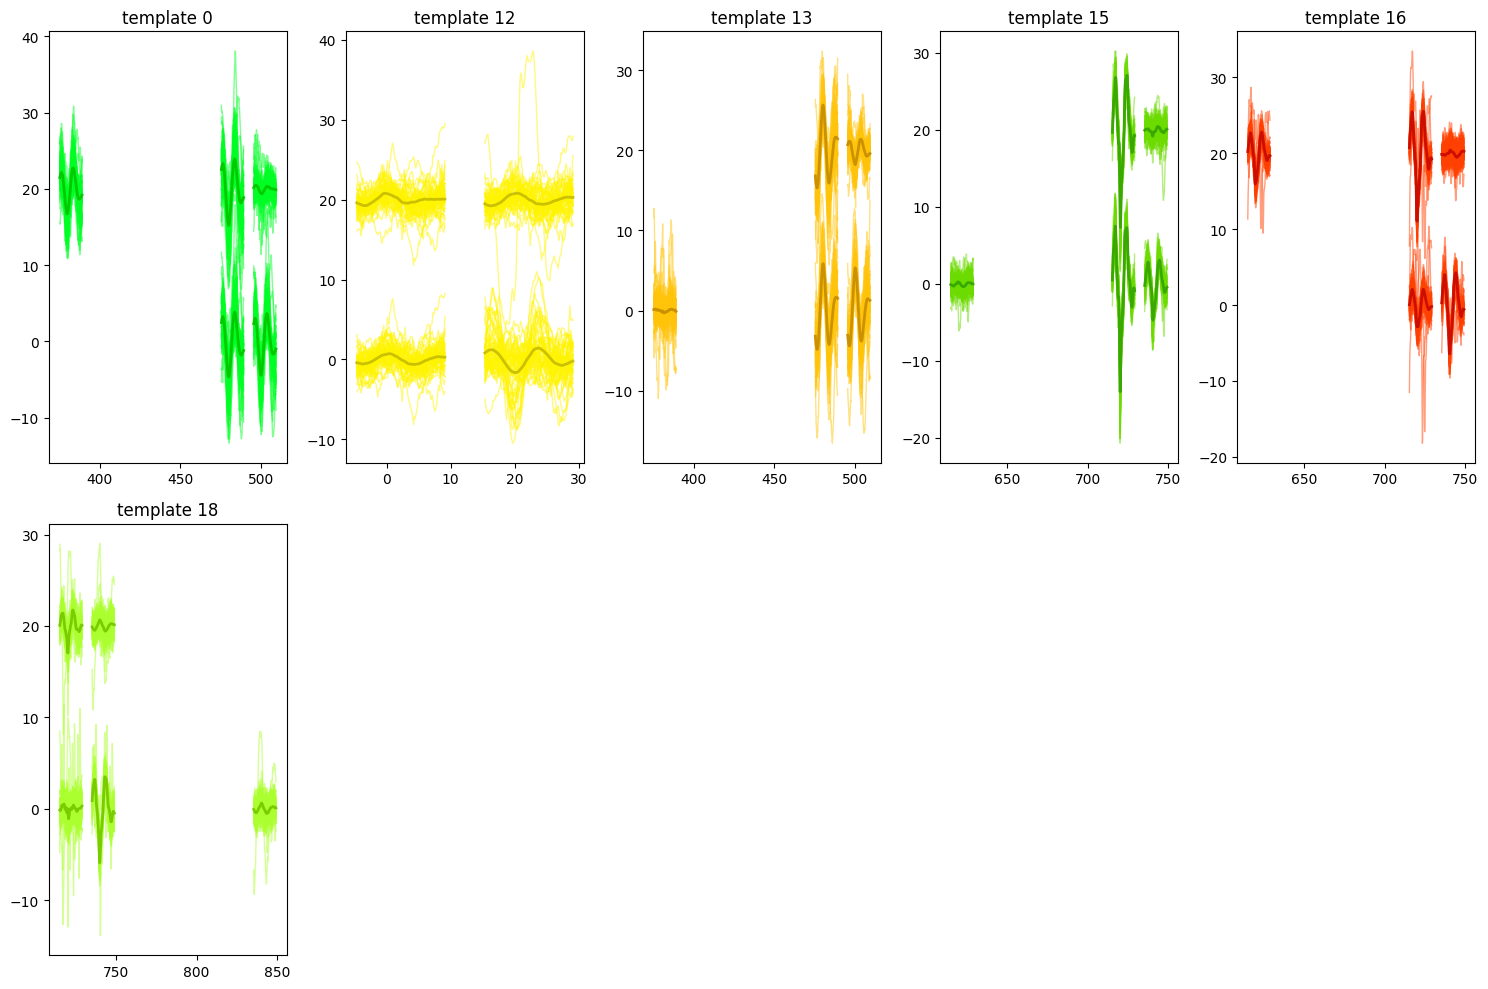


~ Unit Templates on Probe ~


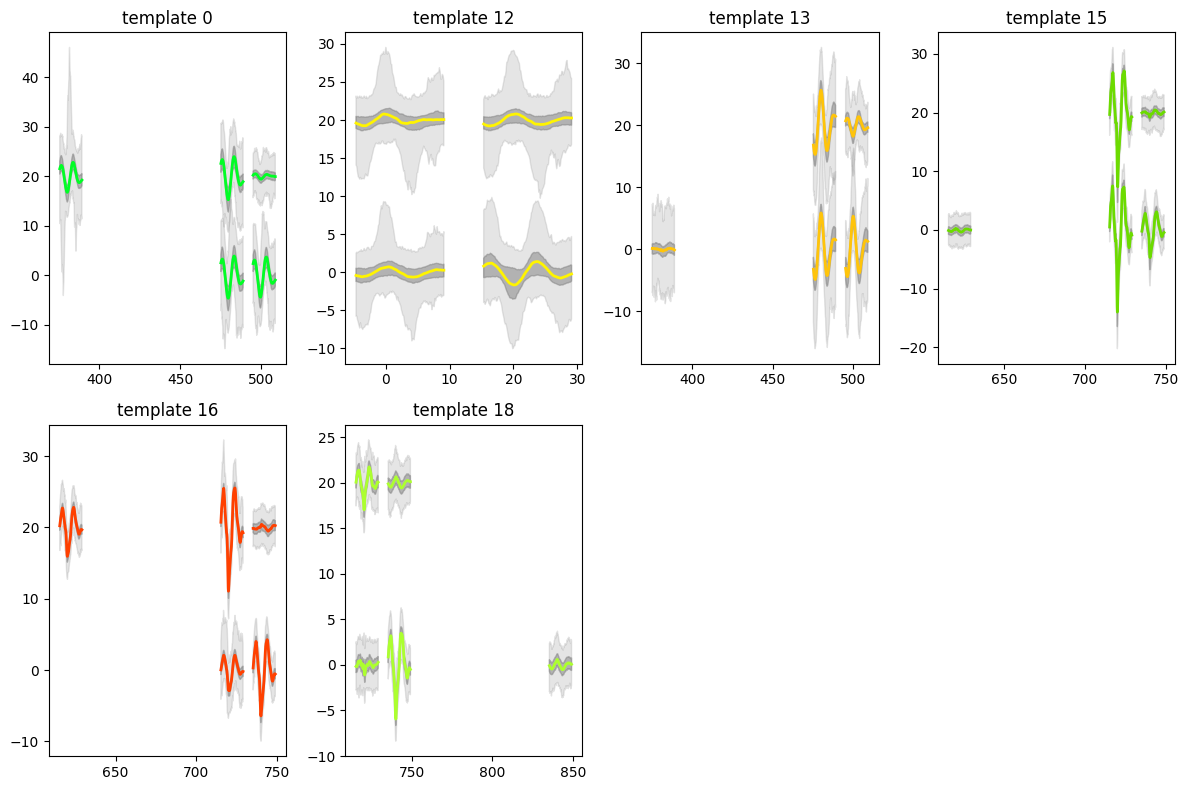


~ Autocorrelograms (Refractory Period Check) ~


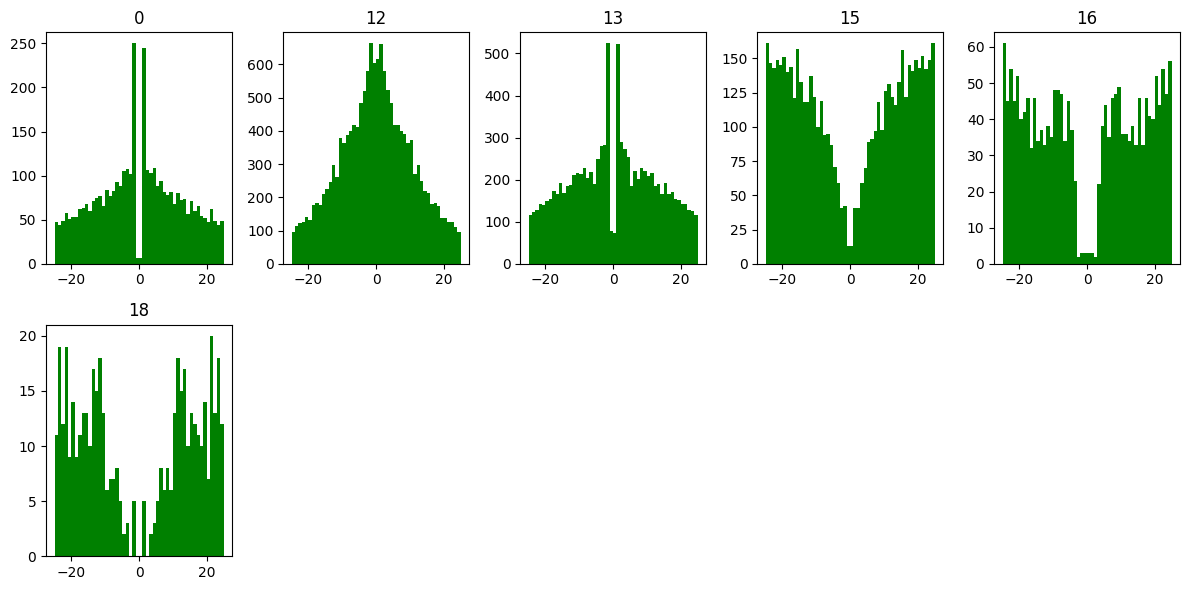


~ Spike Amplitudes Over Time (Drift Check) ~


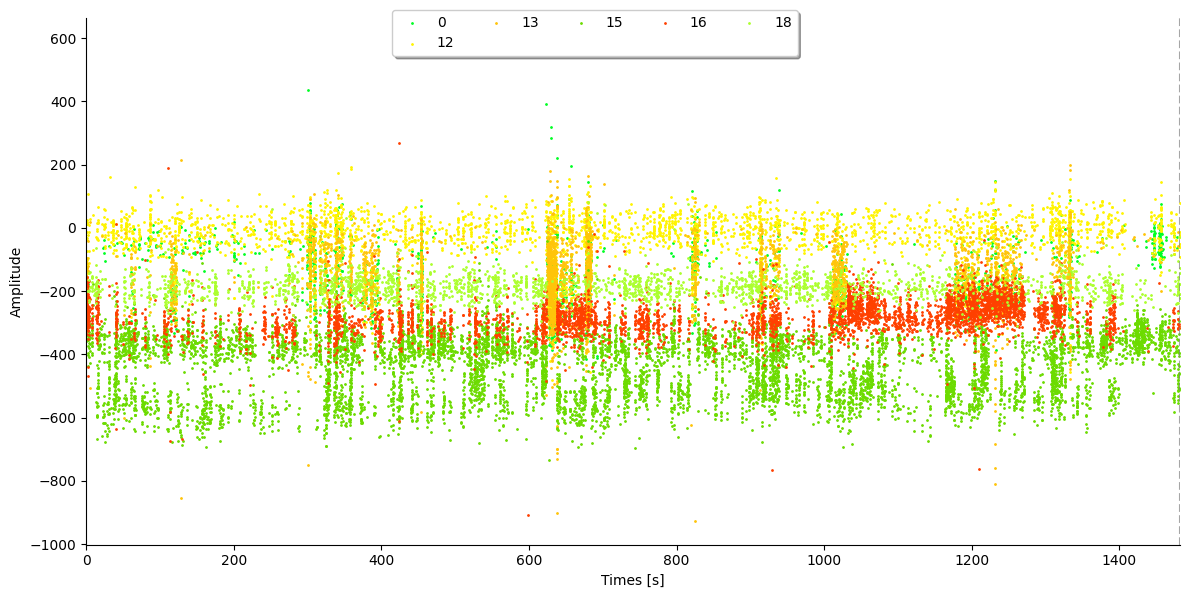


~ Quality Metrics ~


,snr,isi_violations_ratio,isi_violations_count,firing_rate
0,6.306672,12.081744,76.0,1.188678
12,2.227133,23.306272,698.0,2.593662
13,6.032887,13.218526,211.0,1.893529
15,14.506927,0.246002,33.0,5.489211
16,9.457149,0.089459,4.0,3.169133
18,6.106515,0.107613,1.0,1.444742



Saved quality metrics to: /Users/andrewgibson/Neural Crossroads Lab/Trisdesclous Autosorter Sanford Tether/AG_Autosort_Outputs_DL/CH4a_Day2_ArenaFinal_09292023_DL/figures/quality_metrics.csv

~ Unit Summary ~
Unit 0: 1764 spikes, 1.19 Hz
Unit 12: 3849 spikes, 2.59 Hz
Unit 13: 2810 spikes, 1.89 Hz
Unit 15: 8146 spikes, 5.49 Hz
Unit 16: 4703 spikes, 3.17 Hz
Unit 18: 2144 spikes, 1.44 Hz


In [16]:
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt

# pull the most recent sorting analyzer from the sa folder
sa_folder = dl_project_root / pl2_files[0].stem / 'sa'
latest_sa = sorted(sa_folder.glob('*'))[-1]  # grab most recent timestamp

print(f"Loading: {latest_sa}")
analyzer = si.load_sorting_analyzer(latest_sa)

print(f"\nFound {len(analyzer.sorting.unit_ids)} units")

# make a figures output folder
fig_folder = dl_project_root / pl2_files[0].stem / 'figures'
fig_folder.mkdir(parents=True, exist_ok=True)
print(f"\nSaving figures to: {fig_folder}")

# compute extensions we need for plotting (correlograms for refrac period, quality metrics for SNR/ISI/etc)
print("\nComputing correlograms...")
analyzer.compute('correlograms', window_ms=50.0, bin_ms=1.0)

print("Computing noise levels (for later SNR)...")
analyzer.compute('noise_levels')

print("Computing quality metrics...")
analyzer.compute('quality_metrics', metric_names=['snr', 'isi_violation', 'firing_rate'])

# waveforms for each unit across channels
print("\n~ Unit Waveforms ~")
fig = sw.plot_unit_waveforms(analyzer, figsize=(15, 10))
plt.tight_layout()
plt.savefig(fig_folder / 'unit_waveforms.pdf', bbox_inches='tight')
plt.show()

# templates overlaid on probe geometry
print("\n~ Unit Templates on Probe ~")
fig = sw.plot_unit_templates(analyzer, ncols=4, figsize=(12, 8))
plt.tight_layout()
plt.savefig(fig_folder / 'unit_templates.pdf', bbox_inches='tight')
plt.show()

# autocorrelograms to verify refractory period (should see clear dip at 0ms for real neurons)
print("\n~ Autocorrelograms (Refractory Period Check) ~")
fig = sw.plot_autocorrelograms(analyzer, figsize=(12, 6))
plt.tight_layout()
plt.savefig(fig_folder / 'autocorrelograms.pdf', bbox_inches='tight')
plt.show()

# spike amps over time to check for drift or instability
print("\n~ Spike Amplitudes Over Time (Drift Check) ~")
fig = sw.plot_amplitudes(analyzer, figsize=(12, 6))  # correct function name
plt.tight_layout()
plt.savefig(fig_folder / 'spike_amplitudes.pdf', bbox_inches='tight')
plt.show()

# quality metrics table
print("\n~ Quality Metrics ~")
qm = analyzer.get_extension('quality_metrics').get_data()
display(qm)

# save quality metrics as csv too
qm.to_csv(fig_folder / 'quality_metrics.csv')
print(f"\nSaved quality metrics to: {fig_folder / 'quality_metrics.csv'}")

# basic unit summary stats
print("\n~ Unit Summary ~")
for unit_id in analyzer.sorting.unit_ids:
    spike_train = analyzer.sorting.get_unit_spike_train(unit_id)
    duration = analyzer.recording.get_num_frames() / analyzer.recording.get_sampling_frequency()
    firing_rate = len(spike_train) / duration
    print(f"Unit {unit_id}: {len(spike_train)} spikes, {firing_rate:.2f} Hz")

In [17]:
# quality thresholds; this roughly matches my manual sorting showing 3-4 good units
# quality thresholds for exclusive categories
isi_threshold = 2.0  # cutoff for "good" units
snr_threshold = 5.0  # minimum SNR across all categories

# figure out what the ISI column is actually called (handle SI version differences)
isi_col = _find_column_flexible(qm.columns, 
                                 candidates=['isi_violation', 'isi_violations_ratio', 'isi_violations_rate'],
                                 must_contain=['isi', 'viol'])

# convert ISI to percentage if stored as ratio (for consistent thresholding)
if qm[isi_col].max() <= 1.0:
    # stored as ratio, convert to percentage
    qm['isi_pct'] = qm[isi_col] * 100.0
else:
    # already percentage
    qm['isi_pct'] = qm[isi_col]

# (these are exclusive categories)
excellent_units = qm[(qm['isi_pct'] < 0.5) & (qm['snr'] > snr_threshold)].index.tolist()  # <0.5%
good_units = qm[(qm['isi_pct'] >= 0.5) & (qm['isi_pct'] < 2.0) & (qm['snr'] > snr_threshold)].index.tolist()  # 0.5-2%
borderline_units = qm[(qm['isi_pct'] >= 2.0) & (qm['isi_pct'] < 5.0) & (qm['snr'] > snr_threshold)].index.tolist()  # 2-5%
bad_units = qm[(qm['isi_pct'] >= 5.0) | (qm['snr'] <= snr_threshold)].index.tolist()  # >5% or low SNR

# units to keep
all_good_units = excellent_units + good_units  # everything below 2%

print(f"Quality thresholds: ISI cutoffs at 0.5%, 2%, 5%; SNR > {snr_threshold}")
print(f"Excellent units (ISI < 0.5%): {excellent_units}")
print(f"Good units (0.5% ≤ ISI < 2%): {good_units}")
print(f"Borderline units (2% ≤ ISI < 5%): {borderline_units}")
print(f"Rejected units (ISI ≥ 5% or SNR ≤ {snr_threshold}): {bad_units}")
print(f"\nKept {len(all_good_units)}/{len(qm)} units total (excellent + good)")

# save good units (using 2% cutoff)
good_units_mask = (qm['isi_violations_ratio'] < isi_threshold) & (qm['snr'] > snr_threshold)
good_units_df = qm[good_units_mask].copy()
good_units_df['session'] = pl2_files[0].stem
good_units_df.to_csv(fig_folder / 'high_quality_units.csv')

# also save borderline units for manual review in Phy
borderline_mask = (qm['isi_violations_ratio'] >= 2.0) & (qm['isi_violations_ratio'] < 5.0) & (qm['snr'] > snr_threshold)
if borderline_mask.any():
    borderline_df = qm[borderline_mask].copy()
    borderline_df['session'] = pl2_files[0].stem
    borderline_df.to_csv(fig_folder / 'borderline_units_manual_review.csv')
    print(f"\nSaved {len(borderline_df)} borderline units for manual review in Phy")

Quality thresholds: ISI cutoffs at 0.5%, 2%, 5%; SNR > 5.0
Excellent units (ISI < 0.5%): [15, 16, 18]
Good units (0.5% ≤ ISI < 2%): []
Borderline units (2% ≤ ISI < 5%): []
Rejected units (ISI ≥ 5% or SNR ≤ 5.0): [0, 12, 13]

Kept 3/6 units total (excellent + good)
